In [1]:
import numpy as np 
import pandas as pd 
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
#import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 
import torch
from torch import nn
import torch.optim as optim
import torch.utils.data as data
import itertools
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

In [2]:
window_size = 5
train = pd.read_csv("./data/train.csv")
stocks = range(0,200)
train = train.sort_values(['date_id','time_id'])
train['wap'] = train['wap'].fillna(train['wap'].mean())
scaler =  MinMaxScaler()
targetScaler = MinMaxScaler()
train['wap_scaled'] = scaler.fit_transform(train['wap'].to_numpy().reshape(-1, 1)).squeeze()
train['target_scaled'] = scaler.fit_transform(train['target'].to_numpy().reshape(-1, 1)).squeeze()
table = pd.pivot_table(train,values=['wap_scaled','target_scaled'],columns=['stock_id'],index=['date_id','time_id'])


table.fillna(method='bfill',inplace=True)
table.fillna(method='ffill',inplace=True)

print(table.head())
table.isna().sum()

                target_scaled                                          \
stock_id                  0         1         2         3         4     
date_id time_id                                                         
0       0            0.459801  0.456805  0.453353  0.458621  0.454604   
        1            0.463914  0.461496  0.454472  0.462194  0.455362   
        2            0.468521  0.455675  0.455771  0.461003  0.462615   
        3            0.470001  0.457251  0.456445  0.464804  0.460330   
        4            0.467258  0.455326  0.463108  0.460618  0.457551   

                                                                   ...  \
stock_id              5         6         7         8         9    ...   
date_id time_id                                                    ...   
0       0        0.471600  0.460438  0.461088  0.456264  0.473032  ...   
        1        0.472720  0.458297  0.453810  0.462507  0.462675  ...   
        2        0.464660  0.466970  0.448927

               stock_id
target_scaled  0           0
               1           0
               2           0
               3           0
               4           0
                          ..
wap_scaled     195         0
               196         0
               197         0
               198         0
               199         0
Length: 400, dtype: int64

In [3]:
def create_lagged_with_target(data,stock,var,window_size,forecast_dist,target):
    var_data = data[var][stock]
    target_data = data[target][stock]
    y = target_data.iloc[window_size+forecast_dist:]
    var_data = var_data.values.reshape(-1,1)
    n = data.shape[0]
    X = np.hstack(tuple([var_data[i: n-j, :] for i, j in enumerate(range(window_size,0,-1))]))
    X = X[:X.shape[0]-forecast_dist]
    y.reset_index()
    return pd.DataFrame(X,index=y.index).to_numpy(), y.to_numpy()

In [4]:
window_size = 5
    

X_train = {}
y_train = {}
X_test = {}
y_test = {}
for stock in stocks:
    print("getting forcasts for stock: ",stock)

    with open('./models/ensembler/model_{}'.format(stock), 'rb') as handle:
        forecaster = pickle.load(handle)

    X, y = create_lagged_with_target(table,stock,'wap_scaled',window_size,6,'target_scaled')

    size = int(X.shape[0]*.9)
    X_pre_train = X[:size]
    X_pre_test = X[size:]
    X_train[stock] = forecaster.predict(X_pre_train)
    y_train[stock] = y[:size]

    X_test[stock] = forecaster.predict(X_pre_test)
    y_test[stock] = y[size:]

    if stock % 50 == 0 and stock != 0:
        pd.DataFrame(X_train).to_csv('data/eforecasts/X_train_forcasts{0}-{1}'.format(stock-50,stock),index=False)
        pd.DataFrame(y_train).to_csv('data/eforecasts/y_train_forcasts{0}-{1}'.format(stock-50,stock),index=False)
        pd.DataFrame(X_test).to_csv('data/eforecasts/X_test_forcasts{0}-{1}'.format(stock-50,stock),index=False)
        pd.DataFrame(y_test).to_csv('data/eforecasts/y_test_forcasts{0}-{1}'.format(stock-50,stock),index=False)

        X_train = {}
        y_train = {}
        X_test = {}
        y_test = {}
        
pd.DataFrame(X_train).to_csv('data/eforecasts/X_train_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)
pd.DataFrame(y_train).to_csv('data/eforecasts/y_train_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)
pd.DataFrame(X_test).to_csv('data/eforecasts/X_test_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)
pd.DataFrame(y_test).to_csv('data/eforecasts/y_test_forcasts{0}-{1}'.format(stock-50+1,stock+1),index=False)


getting forcasts for stock:  0
getting forcasts for stock:  1
getting forcasts for stock:  2
getting forcasts for stock:  3
getting forcasts for stock:  4
getting forcasts for stock:  5
getting forcasts for stock:  6
getting forcasts for stock:  7
getting forcasts for stock:  8
getting forcasts for stock:  9
getting forcasts for stock:  10
getting forcasts for stock:  11
getting forcasts for stock:  12
getting forcasts for stock:  13
getting forcasts for stock:  14
getting forcasts for stock:  15
getting forcasts for stock:  16
getting forcasts for stock:  17
getting forcasts for stock:  18
getting forcasts for stock:  19
getting forcasts for stock:  20
getting forcasts for stock:  21
getting forcasts for stock:  22
getting forcasts for stock:  23
getting forcasts for stock:  24
getting forcasts for stock:  25
getting forcasts for stock:  26
getting forcasts for stock:  27
getting forcasts for stock:  28
getting forcasts for stock:  29
getting forcasts for stock:  30
getting forcasts f

In [5]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()
for x in range(4):
    X_train = pd.concat([X_train,pd.read_csv('data/eforecasts/X_train_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
    X_test = pd.concat([X_test,pd.read_csv('data/eforecasts/X_test_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
    y_train = pd.concat([y_train,pd.read_csv('data/eforecasts/y_train_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
    y_test = pd.concat([y_test,pd.read_csv('data/eforecasts/y_test_forcasts{0}-{1}'.format(x*50,x*50+50))],axis=1)
                                            

In [6]:

model = MultiOutputRegressor(Ridge())
model.fit(X_train,y_train)
print(model.score(X_test,y_test))

y_hat = model.predict(X_test)


-0.05105353873492795


<Axes: >

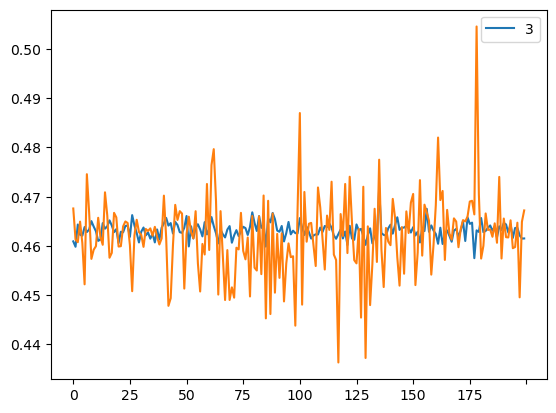

In [7]:
y_hat_df = pd.DataFrame(y_hat)
y_hat_df.iloc[3].plot(legend=True)
y_test.iloc[3].plot()